In [81]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.calibration import CalibratedClassifierCV

In [3]:
#Creating a Print Display file
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols].sort_values(by = ["num_uniques"],ascending = False))
    return pretty_print(df.sort_values(by = ["num_uniques"],ascending = False))

In [4]:
#Creating a dataframe file
def tbl_reportdf(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols].sort_values(by = ["num_uniques"],ascending = False)
    return df.sort_values(by = ["num_uniques"],ascending = False)

In [5]:
#Read the Train file.
df=pd.read_csv("train.csv")
df.head(5)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [6]:
df.shape   #Size of the Entire Train File

(76020, 371)

In [7]:
#Perform the Test Train Split. 70% for training data and 30% for testing data.
df_train, df_test = train_test_split(df, train_size=0.7,random_state = 45)

In [8]:
#Seeing the first five output
df_train.head(5)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
54146,108001,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381623.700000,0
58868,117479,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
57839,115422,2,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120497.430000,0
62591,124963,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47481.960000,0
57708,115187,2,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [9]:
#How many rows and columns the the train file has
df_train.shape

(53214, 371)

In [10]:
#Showing the train file in print display format.
table_report = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (53214, 371)


,dtype,nulls,num_uniques,value_counts
ID,int64,0,53214,HC
var38,float64,0,41013,HC
saldo_medio_var5_ult3,float64,0,13019,HC
saldo_var30,float64,0,12382,HC
saldo_var42,float64,0,11475,HC
saldo_medio_var5_ult1,float64,0,10849,HC
saldo_medio_var5_hace2,float64,0,10738,HC
saldo_var5,float64,0,8546,HC
imp_op_var39_comer_ult3,float64,0,6563,HC
imp_op_var41_comer_ult3,float64,0,6468,HC


In [11]:
# Showing file in a data frame
tabledf = tbl_reportdf(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (53214, 371)


In [12]:
# Data dataframe file
tabledf

,dtype,nulls,num_uniques,value_counts
ID,int64,0,53214,HC
var38,float64,0,41013,HC
saldo_medio_var5_ult3,float64,0,13019,HC
saldo_var30,float64,0,12382,HC
saldo_var42,float64,0,11475,HC
...,...,...,...,...
ind_var27_0,int64,0,1,0:53214
imp_reemb_var13_hace3,int64,0,1,0:53214
num_var27,int64,0,1,0:53214
num_var28,int64,0,1,0:53214


In [13]:
df_train['TARGET'].value_counts() # Imbalance Data Set

0    51106
1     2108
Name: TARGET, dtype: int64

<AxesSubplot:>

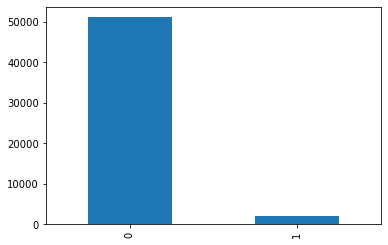

In [14]:
df_train['TARGET'].value_counts().plot(kind='bar') # Barplot of the Imbalance Dataset

#Base Line Models

1) Crude Base Line Model

In [15]:
print('Accuracy of model that predicts all 0s',df_train['TARGET'].value_counts()[0]/(df_train['TARGET'].value_counts()[0]+df_train['TARGET'].value_counts()[1]))

Accuracy of model that predicts all 0s 0.9603863644905476


In [16]:
print('Accuracy of model that predicts all 1s',df_train['TARGET'].value_counts()[1]/(df_train['TARGET'].value_counts()[0]+df_train['TARGET'].value_counts()[1]))

Accuracy of model that predicts all 1s 0.0396136355094524


2) Simple Logistic Regression

In [17]:
clf1 = LogisticRegression()
clf1.fit(df_train.drop(["TARGET"],axis = 1), df_train["TARGET"])
clf1.predict(df_test.drop(["TARGET"],axis = 1))

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
clf1_trainaccuracy= accuracy_score(df_train["TARGET"],clf1.predict(df_train.drop(["TARGET"],axis = 1)))
clf1_trainaccuracy

0.9603863644905476

In [19]:
clf1_testaccuracy= accuracy_score(df_test["TARGET"],clf1.predict(df_test.drop(["TARGET"],axis = 1)))
clf1_testaccuracy

0.9605367008681925

In [20]:
print(confusion_matrix(df_test["TARGET"], clf1.predict(df_test.drop(["TARGET"],axis = 1))))

[[21906     0]
 [  900     0]]


In [21]:
def make_roc(name, clf, ytest, xtest, ax=None, label=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],label):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax 

<AxesSubplot:>

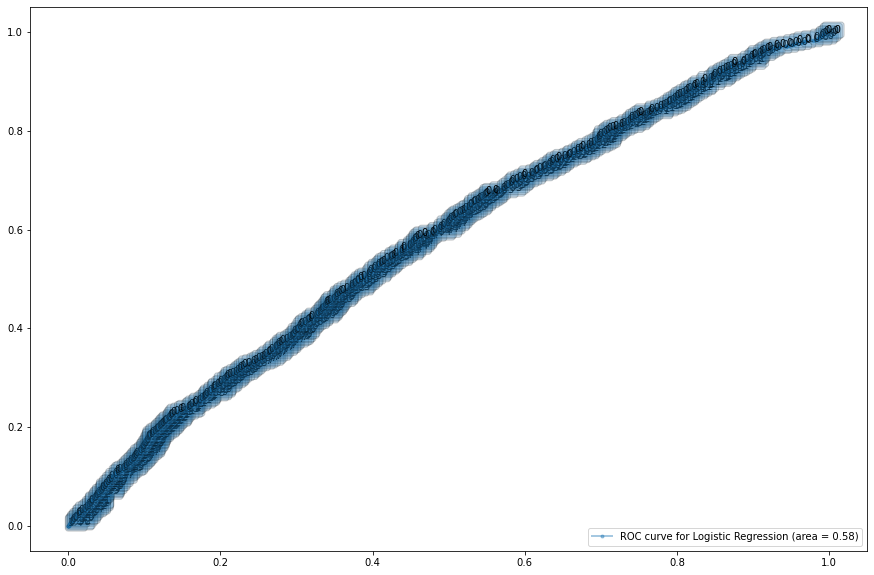

In [22]:
fig,ax = plt.subplots(figsize=(15,10))
make_roc('Logistic Regression',clf1,df_test["TARGET"],df_test.drop(["TARGET"],axis = 1),ax=ax)

In [23]:
print(classification_report(df_test["TARGET"], clf1.predict(df_test.drop(["TARGET"],axis = 1))))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21906
           1       0.00      0.00      0.00       900

    accuracy                           0.96     22806
   macro avg       0.48      0.50      0.49     22806
weighted avg       0.92      0.96      0.94     22806



/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

3) Logistic Regression with Regularization

In [24]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

In [25]:
clf2 = LogisticRegression()
gs = GridSearchCV(clf2, param_grid=parameters, cv=5) # 5-fold
gs.fit(df_train.drop(["TARGET"],axis = 1), df_train["TARGET"])
print("BEST", gs.best_params_, gs.best_score_)
best = gs.best_estimator_
best.fit(df_train.drop(["TARGET"],axis = 1), df_train["TARGET"])
clf2_trainingaccuracy = best.score(df_train.drop(["TARGET"],axis = 1), df_train["TARGET"])
clf2_testaccuracy = best.score(df_test.drop(["TARGET"],axis = 1), df_test["TARGET"])
print("############# based on standard predict ################")
print("Accuracy on training data:", (clf2_trainingaccuracy))
print("Accuracy on test data:", (clf2_testaccuracy))
print(confusion_matrix(df_test["TARGET"], best.predict(df_test.drop(["TARGET"],axis = 1))))

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

BEST {'C': 0.001} 0.9603675737999993
############# based on standard predict ################
Accuracy on training data: 0.9603863644905476
Accuracy on test data: 0.9605367008681925
[[21906     0]
 [  900     0]]


<AxesSubplot:>

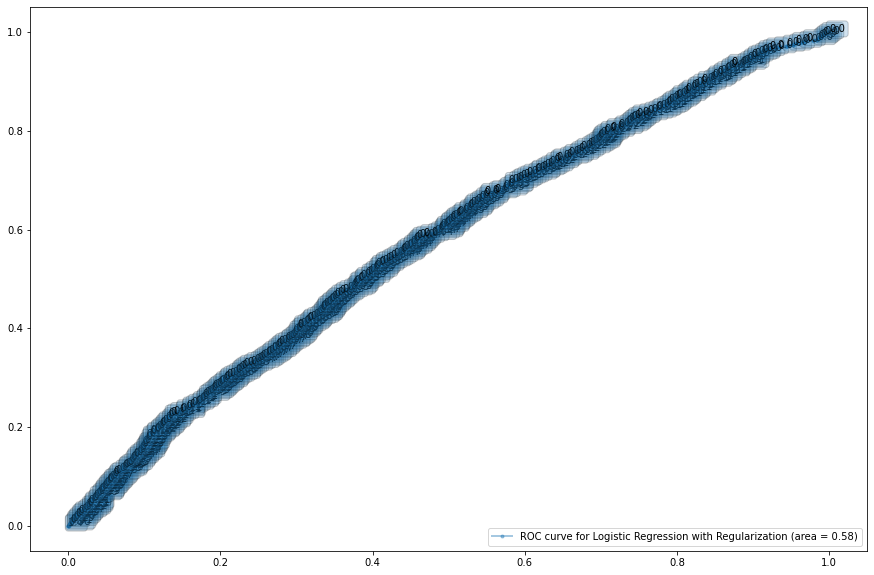

In [26]:
fig,ax = plt.subplots(figsize=(15,10))
make_roc('Logistic Regression with Regularization',best,df_test["TARGET"],df_test.drop(["TARGET"],axis = 1),ax=ax)

In [27]:
print(classification_report(df_test["TARGET"], best.predict(df_test.drop(["TARGET"],axis = 1))))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21906
           1       0.00      0.00      0.00       900

    accuracy                           0.96     22806
   macro avg       0.48      0.50      0.49     22806
weighted avg       0.92      0.96      0.94     22806



/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Beyond Baseline Model

In [28]:
#Getting rid of only one unique values
newtabledf = tabledf[tabledf["num_uniques"]>1]
newtabledf

,dtype,nulls,num_uniques,value_counts
ID,int64,0,53214,HC
var38,float64,0,41013,HC
saldo_medio_var5_ult3,float64,0,13019,HC
saldo_var30,float64,0,12382,HC
saldo_var42,float64,0,11475,HC
...,...,...,...,...
imp_reemb_var33_ult1,int64,0,2,0:53213\n1200:1
ind_var10_ult1,int64,0,2,0:48936\n1:4278
ind_var25_0,int64,0,2,0:51944\n1:1270
ind_var7_recib_ult1,int64,0,2,0:53066\n1:148


In [29]:
#The train data set after removing only one unique values
df_train = df_train[newtabledf.index]
df_train

,ID,var38,saldo_medio_var5_ult3,saldo_var30,saldo_var42,saldo_medio_var5_ult1,saldo_medio_var5_hace2,saldo_var5,imp_op_var39_comer_ult3,imp_op_var41_comer_ult3,...,ind_var43_emit_ult1,ind_var9_ult1,ind_var9_cte_ult1,delta_imp_amort_var18_1y3,ind_var25,imp_reemb_var33_ult1,ind_var10_ult1,ind_var25_0,ind_var7_recib_ult1,ind_var7_emit_ult1
54146,108001,381623.700000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
58868,117479,117310.979016,247.53,450.00,450.00,450.00,45.03,450.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
57839,115422,120497.430000,22.32,150030.00,30.00,30.00,30.00,30.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
62591,124963,47481.960000,2.61,3.00,3.00,3.00,3.00,3.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
57708,115187,117310.979016,246.66,300.00,300.00,300.00,300.00,300.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12895,25851,73473.300000,2.73,3.00,3.00,3.00,3.00,3.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
60960,121686,54877.260000,668.04,3120.72,3120.72,1936.41,60.00,3120.72,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
6012,12082,45209.430000,32.22,48.00,48.00,48.00,48.00,48.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
63107,126014,117310.979016,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Removing all repeated columns
combinations = list(itertools.combinations(df_train.columns,2)) #getting all the combinations of columns
remove=[]
for f1,f2 in combinations: #finding all columns which have same datavalues, they don't share same feature name
    if (f1 not in remove) & (f2 not in remove):
        if df_train[f1].equals(df_train[f2]):
            remove.append(f1)
df_train.drop(remove,axis=1,inplace=True)

In [31]:
# The train data set after removing all repeated coulmns
df_train

,ID,var38,saldo_medio_var5_ult3,saldo_var30,saldo_var42,saldo_medio_var5_ult1,saldo_medio_var5_hace2,saldo_var5,imp_op_var39_comer_ult3,imp_op_var41_comer_ult3,...,ind_var43_recib_ult1,ind_var43_emit_ult1,ind_var9_ult1,ind_var9_cte_ult1,delta_imp_amort_var18_1y3,imp_reemb_var33_ult1,ind_var10_ult1,ind_var25_0,ind_var7_recib_ult1,ind_var7_emit_ult1
54146,108001,381623.700000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
58868,117479,117310.979016,247.53,450.00,450.00,450.00,45.03,450.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
57839,115422,120497.430000,22.32,150030.00,30.00,30.00,30.00,30.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
62591,124963,47481.960000,2.61,3.00,3.00,3.00,3.00,3.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
57708,115187,117310.979016,246.66,300.00,300.00,300.00,300.00,300.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12895,25851,73473.300000,2.73,3.00,3.00,3.00,3.00,3.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
60960,121686,54877.260000,668.04,3120.72,3120.72,1936.41,60.00,3120.72,0.00,0.00,...,1,0,0,0,0,0,0,0,0,0
6012,12082,45209.430000,32.22,48.00,48.00,48.00,48.00,48.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
63107,126014,117310.979016,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# The correlation among all variables in train file
corr_df_train = df_train.corr()
corr_df_train

,ID,var38,saldo_medio_var5_ult3,saldo_var30,saldo_var42,saldo_medio_var5_ult1,saldo_medio_var5_hace2,saldo_var5,imp_op_var39_comer_ult3,imp_op_var41_comer_ult3,...,ind_var43_recib_ult1,ind_var43_emit_ult1,ind_var9_ult1,ind_var9_cte_ult1,delta_imp_amort_var18_1y3,imp_reemb_var33_ult1,ind_var10_ult1,ind_var25_0,ind_var7_recib_ult1,ind_var7_emit_ult1
ID,1.000000,-0.005607,-0.003941,-0.005647,-0.007656,-0.004197,-0.003254,-0.004162,-0.002055,-0.000144,...,-0.003657,-0.004114,0.001891,0.001506,0.005885,-0.002594,0.001018,0.000256,-0.001030,0.002913
var38,-0.005607,1.000000,0.049673,0.032380,0.021374,0.048609,0.044800,0.047885,0.007275,0.006559,...,0.012248,-0.007104,-0.002287,0.000972,0.009153,0.002451,-0.005758,-0.003260,-0.000502,-0.000999
saldo_medio_var5_ult3,-0.003941,0.049673,1.000000,0.341284,0.296752,0.835109,0.716561,0.650299,0.026573,0.021155,...,0.077836,0.078506,0.029057,0.033676,-0.000746,-0.000528,0.017909,-0.009055,0.047786,0.004663
saldo_var30,-0.005647,0.032380,0.341284,1.000000,0.798522,0.223225,0.399052,0.161454,-0.009392,-0.016296,...,0.090254,0.076603,0.006069,0.023877,-0.000402,-0.000943,-0.016850,0.001777,0.057004,-0.001070
saldo_var42,-0.007656,0.021374,0.296752,0.798522,1.000000,0.237868,0.317535,0.201185,0.005001,-0.000397,...,0.116618,0.101534,0.019626,0.041495,0.000288,-0.000630,0.002254,0.009237,0.048802,-0.000558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imp_reemb_var33_ult1,-0.002594,0.002451,-0.000528,-0.000943,-0.000630,-0.000467,-0.000547,-0.000435,-0.000951,-0.000961,...,-0.001669,-0.001151,-0.001326,-0.001416,-0.000027,1.000000,-0.001282,-0.000678,-0.000229,-0.000027
ind_var10_ult1,0.001018,-0.005758,0.017909,-0.016850,0.002254,0.028453,0.013440,0.030007,0.323971,0.315020,...,0.309878,0.283311,0.966486,0.905109,0.009461,-0.001282,1.000000,0.528845,0.051316,-0.001813
ind_var25_0,0.000256,-0.003260,-0.009055,0.001777,0.009237,-0.006722,-0.000263,-0.001979,0.226513,0.231024,...,0.098847,0.210550,0.511121,0.478662,0.019125,-0.000678,0.528845,1.000000,0.026810,-0.000959
ind_var7_recib_ult1,-0.001030,-0.000502,0.047786,0.057004,0.048802,0.065135,0.022170,0.052261,0.045048,0.045873,...,0.043540,0.062195,0.054000,0.056491,-0.000324,-0.000229,0.051316,0.026810,1.000000,-0.000324


In [33]:
#The correlation of all dependent variables with dependent variable (i.e., Target variable)
cordf_train = corr_df_train[["TARGET"]]
cordf_train

,TARGET
ID,0.004090
var38,-0.017884
saldo_medio_var5_ult3,-0.018802
saldo_var30,-0.039154
saldo_var42,-0.025251
...,...
imp_reemb_var33_ult1,-0.000880
ind_var10_ult1,0.008693
ind_var25_0,0.017479
ind_var7_recib_ult1,0.002080


In [34]:
# taking absolute values of correlations
cordf_train["axtarget"]= abs(cordf_train["TARGET"])
cordf_train

<ipython-input-34-6d40c1339e0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cordf_train["axtarget"]= abs(cordf_train["TARGET"])


,TARGET,axtarget
ID,0.004090,0.004090
var38,-0.017884,0.017884
saldo_medio_var5_ult3,-0.018802,0.018802
saldo_var30,-0.039154,0.039154
saldo_var42,-0.025251,0.025251
...,...,...
imp_reemb_var33_ult1,-0.000880,0.000880
ind_var10_ult1,0.008693,0.008693
ind_var25_0,0.017479,0.017479
ind_var7_recib_ult1,0.002080,0.002080


In [35]:
#Arrange all variables in descending order (From highest correlation to lowest correlation)
cordf_train = cordf_train.sort_values(by = ["axtarget"],ascending = False)
cordf_train

,TARGET,axtarget
TARGET,1.000000,1.000000
ind_var30,-0.152187,0.152187
num_meses_var5_ult3,-0.149880,0.149880
num_var30,-0.141923,0.141923
num_var42,-0.137347,0.137347
...,...,...
delta_num_reemb_var13_1y3,-0.000131,0.000131
num_reemb_var13_ult1,-0.000131,0.000131
num_op_var40_comer_ult1,0.000119,0.000119
delta_imp_compra_var44_1y3,-0.000063,0.000063


In [36]:
# The print file while sorting the correlation values with the target variables
pretty_print(cordf_train.sort_values(by = ["axtarget"],ascending = False))

,TARGET,axtarget
TARGET,1.000000,1.000000
ind_var30,-0.152187,0.152187
num_meses_var5_ult3,-0.149880,0.149880
num_var30,-0.141923,0.141923
num_var42,-0.137347,0.137347
ind_var5,-0.137109,0.137109
num_var5,-0.136219,0.136219
var36,0.103874,0.103874
var15,0.101073,0.101073
num_var4,-0.081383,0.081383


In [37]:
#Eliminating all independent variables having correlation less than 0.05 
cordf_train = cordf_train.loc[cordf_train["axtarget"]>0.05]
cordf_train

,TARGET,axtarget
TARGET,1.000000,1.000000
ind_var30,-0.152187,0.152187
num_meses_var5_ult3,-0.149880,0.149880
num_var30,-0.141923,0.141923
num_var42,-0.137347,0.137347
ind_var5,-0.137109,0.137109
num_var5,-0.136219,0.136219
var36,0.103874,0.103874
var15,0.101073,0.101073
num_var4,-0.081383,0.081383


In [38]:
# The shape of the train data set after eliminating correlation less than 0.05
cordf_train.shape

(11, 2)

In [39]:
# The train data set after eliminating correlation less than 0.05
df_train = df[cordf_train.index]
df_train

,TARGET,ind_var30,num_meses_var5_ult3,num_var30,num_var42,ind_var5,num_var5,var36,var15,num_var4,num_var35
0,0,0,0,0,0,0,0,99,23,0,0
1,0,1,1,3,0,0,0,3,34,1,3
2,0,1,3,3,3,1,3,99,23,1,3
3,0,1,2,3,3,1,3,2,37,3,9
4,0,1,3,3,3,0,0,1,39,1,3
...,...,...,...,...,...,...,...,...,...,...,...
76015,0,0,0,0,0,0,0,99,48,0,0
76016,0,1,1,3,3,0,0,2,39,1,3
76017,0,1,2,3,3,1,3,99,23,1,3
76018,0,1,3,3,3,1,3,99,25,1,3


In [40]:
# The print pdf of the train file containing 11 independent variables
table_report = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (76020, 11)


,dtype,nulls,num_uniques,value_counts
var15,int64,0,100,HC
num_var35,int64,0,13,HC
num_var30,int64,0,9,3:514520:203106:39019:31912:2815:733:121:118:1
num_var4,int64,0,8,1:381470:195282:126923:43774:10315:2036:367:6
num_var42,int64,0,7,3:520640:219086:20129:3112:318:115:1
num_var5,int64,0,5,3:502650:255616:1909:315:1
var36,int64,0,5,99:300643:221771:146642:87040:411
num_meses_var5_ult3,int64,0,4,3:428380:205462:93681:3268
TARGET,int64,0,2,0:730121:3008
ind_var30,int64,0,2,1:557100:20310


In [41]:
# Checking for multicollinearity using Variance Inflation factor
# VIF dataframe
vif_train = pd.DataFrame()
vif_train["feature"] = df_train.drop(["TARGET"],axis = 1).columns
  
# calculating VIF for each feature
vif_train["VIF"] = [variance_inflation_factor(df_train.drop(["TARGET"],axis = 1).values, i)
                          for i in range(len(df_train.drop(["TARGET"],axis = 1).columns))]
  
print(vif_train)
#VIF > 10 (very high multicollinearity)

               feature         VIF
0            ind_var30   32.918679
1  num_meses_var5_ult3   23.647568
2            num_var30   22.351151
3            num_var42   28.665197
4             ind_var5  299.947969
5             num_var5  292.277513
6                var36    1.885655
7                var15    5.129938
8             num_var4   90.118964
9            num_var35   83.300579


In [42]:
# Drop ind_var5, num_meses_var5_ult3,ind_var30 
# VIF dataframe
vif_train = pd.DataFrame()
vif_train["feature"] = df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30"],axis = 1).columns
  
# calculating VIF for each feature
vif_train["VIF"] = [variance_inflation_factor(df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30"],axis = 1).values, i)
                          for i in range(len(df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30"],axis = 1).columns))]
  
print(vif_train)
#VIF > 10 (very high multicollinearity)

     feature        VIF
0  num_var30  19.806219
1  num_var42  26.957075
2   num_var5  10.286470
3      var36   1.872162
4      var15   4.857816
5   num_var4  74.946135
6  num_var35  70.468184


In [43]:
# Drop num_var35
# VIF dataframe
vif_train = pd.DataFrame()
vif_train["feature"] = df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30","num_var35"],axis = 1).columns
  
# calculating VIF for each feature
vif_train["VIF"] = [variance_inflation_factor(df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30","num_var35"],axis = 1).values, i)
                          for i in range(len(df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30","num_var35"],axis = 1).columns))]
  
print(vif_train)
#VIF > 10 (very high multicollinearity)

     feature        VIF
0  num_var30  19.492435
1  num_var42  26.829431
2   num_var5  10.274044
3      var36   1.872052
4      var15   4.850040
5   num_var4   5.996863


In [44]:
# Drop num_var42
# VIF dataframe
vif_train = pd.DataFrame()
vif_train["feature"] = df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30","num_var35","num_var42"],axis = 1).columns
  
# calculating VIF for each feature
vif_train["VIF"] = [variance_inflation_factor(df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30","num_var35","num_var42"],axis = 1).values, i)
                          for i in range(len(df_train.drop(["TARGET","ind_var5","num_meses_var5_ult3","ind_var30","num_var35","num_var42"],axis = 1).columns))]
  
print(vif_train)
#VIF > 10 (very high multicollinearity)

     feature        VIF
0  num_var30  12.289527
1   num_var5   6.360951
2      var36   1.861907
3      var15   4.831343
4   num_var4   5.549413


EDA on following variables:  num_var30, num_var5, var36, var15, num_var4 

In [45]:
train_features = ["num_var30","num_var5","var36","var15","num_var4","TARGET"]
df_train_features = df_train[train_features]
df_train_features

,num_var30,num_var5,var36,var15,num_var4,TARGET
0,0,0,99,23,0,0
1,3,0,3,34,1,0
2,3,3,99,23,1,0
3,3,3,2,37,3,0
4,3,0,1,39,1,0
...,...,...,...,...,...,...
76015,0,0,99,48,0,0
76016,3,0,2,39,1,0
76017,3,3,99,23,1,0
76018,3,3,99,25,1,0


In [52]:
df_test_features = df_test[train_features]
df_test_features

,num_var30,num_var5,var36,var15,num_var4,TARGET
31447,3,3,3,43,1,0
1224,3,3,3,23,1,0
25163,3,3,99,57,1,1
62435,0,0,99,23,0,0
5024,3,3,1,28,3,0
...,...,...,...,...,...,...
6581,3,3,2,22,1,0
55526,0,0,99,59,0,0
21210,3,3,3,23,1,0
54357,3,3,3,29,2,0


In [46]:
tbl_report(df_train_features, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (76020, 6)


,dtype,nulls,num_uniques,value_counts
var15,int64,0,100,HC
num_var30,int64,0,9,3:514520:203106:39019:31912:2815:733:121:118:1
num_var4,int64,0,8,1:381470:195282:126923:43774:10315:2036:367:6
num_var5,int64,0,5,3:502650:255616:1909:315:1
var36,int64,0,5,99:300643:221771:146642:87040:411
TARGET,int64,0,2,0:730121:3008


array([[<AxesSubplot:title={'center':'num_var30'}>,
        <AxesSubplot:title={'center':'num_var5'}>],
       [<AxesSubplot:title={'center':'var36'}>,
        <AxesSubplot:title={'center':'var15'}>],
       [<AxesSubplot:title={'center':'num_var4'}>,
        <AxesSubplot:title={'center':'TARGET'}>]], dtype=object)

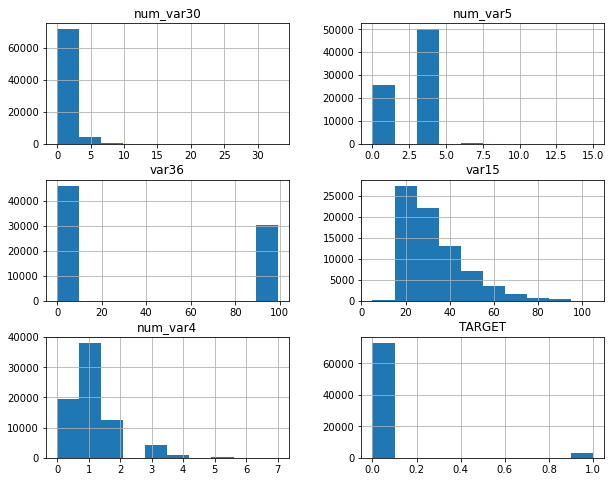

In [47]:
df_train_features.hist(figsize = (10, 8)) #Histograme of selections

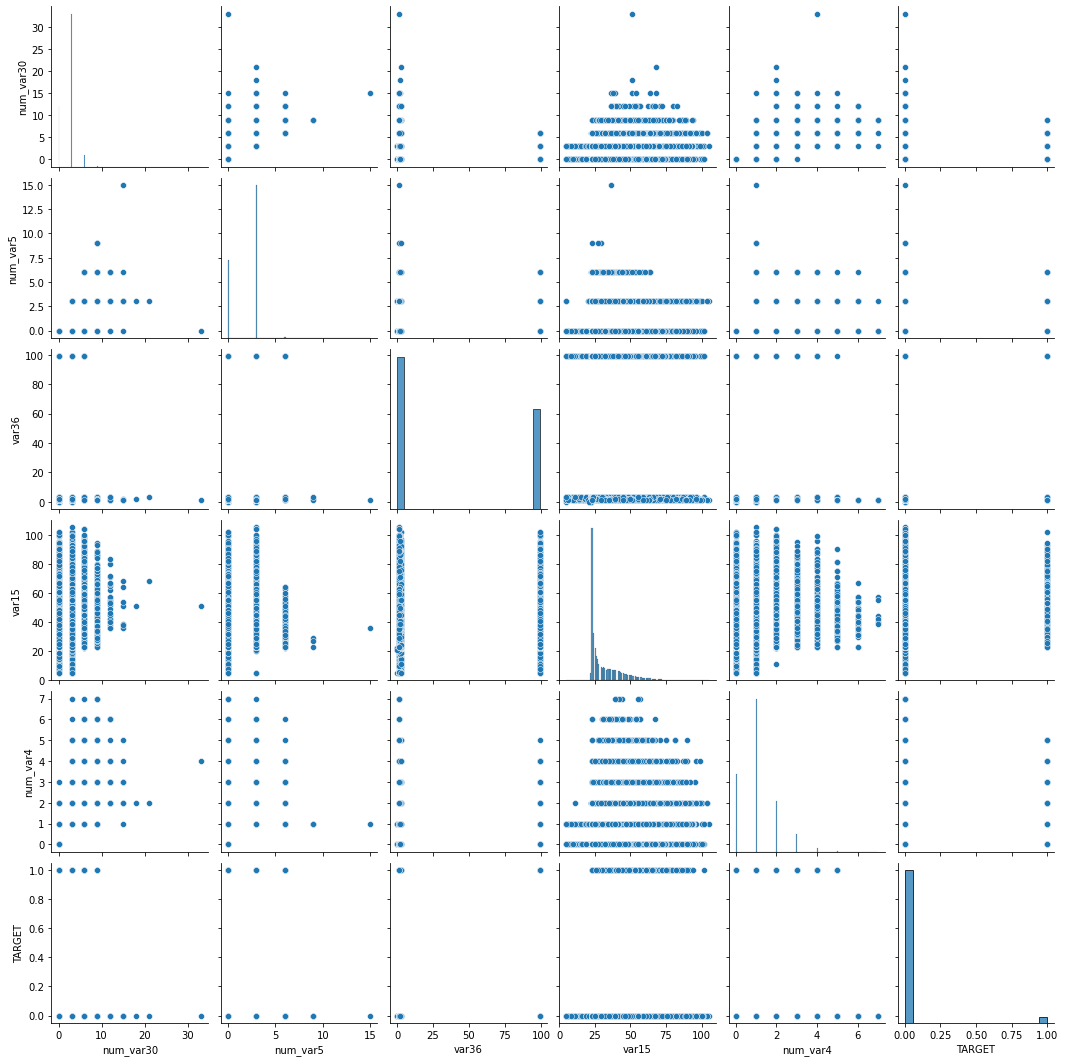

In [48]:
sns.pairplot(data=df_train_features)

In [49]:
round(df_train_features.describe(),2)

,num_var30,num_var5,var36,var15,num_var4,TARGET
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,2.38,2.00,40.45,33.21,1.08,0.04
std,1.64,1.43,47.36,12.96,0.91,0.19
min,0.00,0.00,0.00,5.00,0.00,0.00
25%,0.00,0.00,2.00,23.00,0.00,0.00
50%,3.00,3.00,3.00,28.00,1.00,0.00
75%,3.00,3.00,99.00,40.00,1.00,0.00
max,33.00,15.00,99.00,105.00,7.00,1.00


ENSEMBLE MODELS

Random Forest

In [50]:
rforest = RandomForestClassifier(random_state=42)
n_estimator = [1,3,5]
max_depth = [2,5,10]
max_features = [2,5,10]
min_samples_split = [2,5,10]
param_grid = {'n_estimators':n_estimator,'max_depth':max_depth,'max_features':max_features,'min_samples_split':min_samples_split}
RF_model = GridSearchCV(estimator=rforest,param_grid=param_grid,cv=10,scoring='accuracy')
RF_model.fit(df_train_features.drop(["TARGET"],axis =1),df_train_features["TARGET"])

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/saivenkatmallela/opt

{'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 1}

In [61]:
RF_model.best_params_

{'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 1}

<AxesSubplot:>

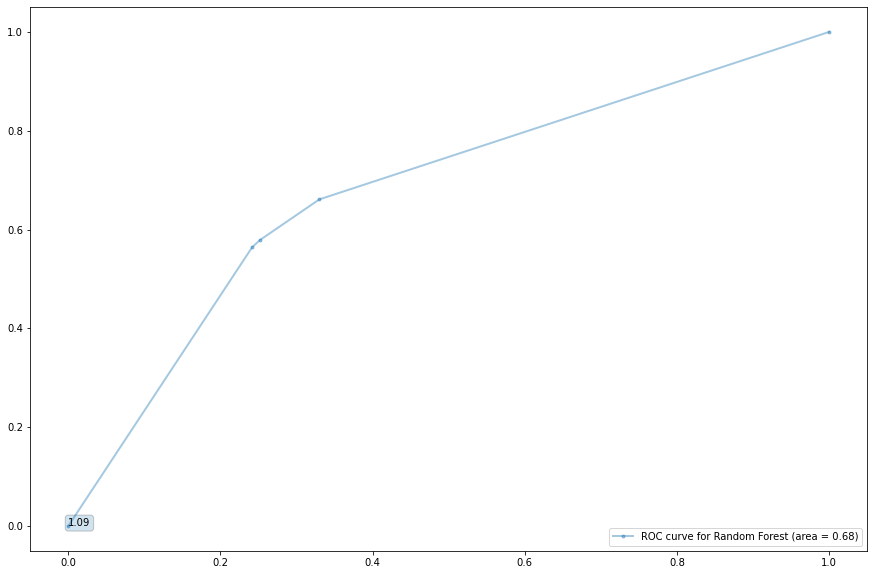

In [53]:
fig,ax = plt.subplots(figsize=(15,10))
make_roc('Random Forest',RF_model.best_estimator_,df_test_features["TARGET"],df_test_features.drop(["TARGET"],axis = 1),ax=ax)

In [55]:
print(classification_report(df_test_features["TARGET"], RF_model.best_estimator_.predict(df_test_features.drop(["TARGET"],axis = 1))))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21906
           1       0.00      0.00      0.00       900

    accuracy                           0.96     22806
   macro avg       0.48      0.50      0.49     22806
weighted avg       0.92      0.96      0.94     22806



/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saivenkatmallela/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [62]:
print(confusion_matrix(df_test_features["TARGET"], RF_model.best_estimator_.predict(df_test_features.drop(["TARGET"],axis = 1))))

[[21906     0]
 [  900     0]]


Bagging

In [57]:
bagged_tree = BaggingClassifier(random_state=42)
n_estimator = [1,3,5]
param_grid = {'n_estimators':n_estimator}
BG_model = GridSearchCV(estimator=bagged_tree,param_grid=param_grid,cv=10,scoring='accuracy')
BG_model.fit(df_train_features.drop(["TARGET"],axis =1),df_train_features["TARGET"])

GridSearchCV(cv=10, estimator=BaggingClassifier(random_state=42),
             param_grid={'n_estimators': [1, 3, 5]}, scoring='accuracy')

In [60]:
BG_model.best_params_

{'n_estimators': 5}

<AxesSubplot:>

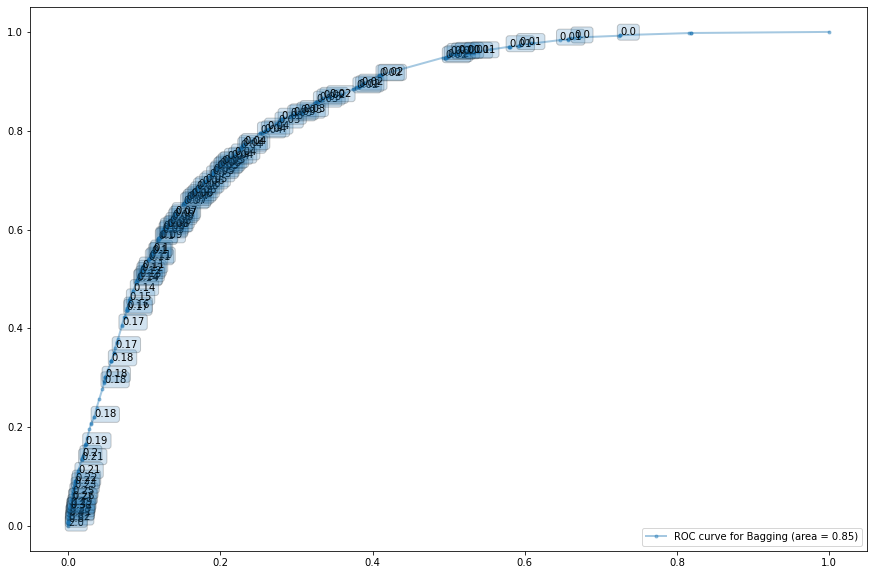

In [58]:
fig,ax = plt.subplots(figsize=(15,10))
make_roc('Bagging',BG_model.best_estimator_,df_test_features["TARGET"],df_test_features.drop(["TARGET"],axis = 1),ax=ax)

In [59]:
print(classification_report(df_test_features["TARGET"], BG_model.best_estimator_.predict(df_test_features.drop(["TARGET"],axis = 1))))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21906
           1       0.58      0.02      0.03       900

    accuracy                           0.96     22806
   macro avg       0.77      0.51      0.51     22806
weighted avg       0.95      0.96      0.94     22806



In [63]:
print(confusion_matrix(df_test_features["TARGET"], BG_model.best_estimator_.predict(df_test_features.drop(["TARGET"],axis = 1))))

[[21895    11]
 [  885    15]]


In [64]:
def plot_permute_importance(result1, result2,X,y):
#     maxlim = max(max(result1.importances_mean),max(result2.importances_mean))
    #plt.xkcd(scale=0.3,randomness=0.6)
    # Plot for random forest
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    tree_importance_sorted_idx = np.argsort(result1.importances_mean)
    tree_indices = np.arange(0, len(result1.importances_mean)) +0.5

    ax1.barh(tree_indices, result1.importances_mean[tree_importance_sorted_idx], 
              height=0.7, color='#B2D7D0')
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(X.columns[tree_importance_sorted_idx], fontsize=12)
    ax1.set_ylim((0, len(result1.importances_mean)))
    ax1.set_xlabel("Permutation Feature Importance", fontsize=16)

    #ax1.set_ylabel("Predictors", fontsize=16)

  # Plot for Bagging

    tree_importance_sorted_idx2 = np.argsort(result2.importances_mean)
    tree_indices2 = np.arange(0, len(result2.importances_mean)) +0.5
    difference = result2['importances_mean'] - result1['importances_mean']
    difference = difference[tree_importance_sorted_idx]

    ax2.barh(tree_indices2, result2.importances_mean[tree_importance_sorted_idx2], 
              height=0.7, color='#EFAEA4')
    for index, value in enumerate(result2.importances_mean[tree_importance_sorted_idx2]):
        ax2.text(value, index+0.3, f" {str(round(difference[index],3))}",fontsize=14)

    ax2.set_yticks(tree_indices2)
    ax2.set_yticklabels(X.columns[tree_importance_sorted_idx2], fontsize=12)
    ax2.set_ylim((0, len(result2.importances_mean)))
    ax2.set_xlabel("Permutation Feature Importance", fontsize=16)
    maxlim = max(result2.importances_mean)
    ax2.set_xlim(0,maxlim+0.015)
    ax1.set_title("Bagged", fontsize=18)
    ax2.set_title("Random Forest", fontsize=18)
    fig.tight_layout()
    plt.show()

In [67]:
rfp = permutation_importance(RF_model.best_estimator_,df_train_features.drop(["TARGET"],axis =1),df_train_features["TARGET"],random_state=42)
bgp = permutation_importance(BG_model.best_estimator_,df_train_features.drop(["TARGET"],axis =1),df_train_features["TARGET"],random_state=42)

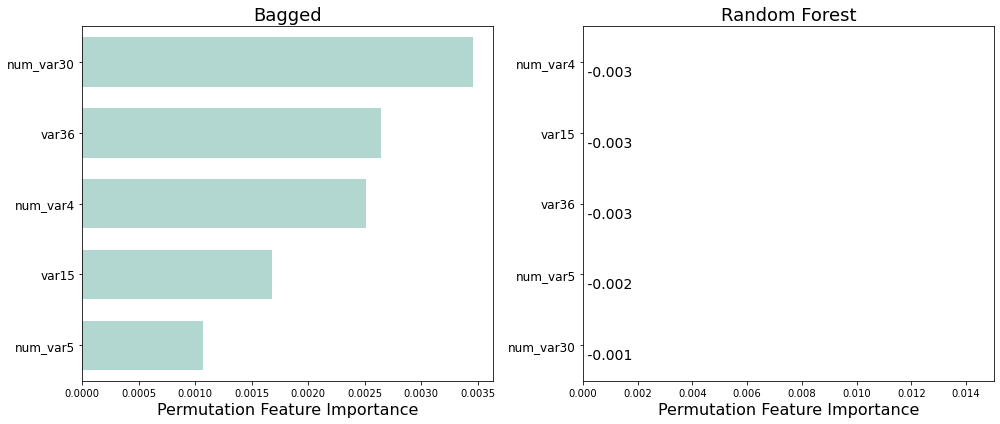

In [68]:
plot_permute_importance(bgp,rfp,df_train_features.drop(["TARGET"],axis =1),df_train_features["TARGET"])

Lets choose the best bagged model since it has better performance and look deeper into it

Probability histogram

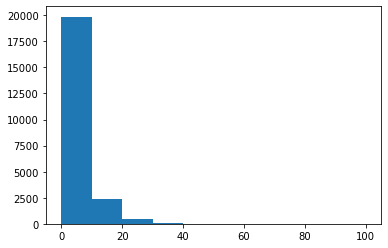

In [70]:
plt.hist(BG_model.best_estimator_.predict_proba(df_test_features.drop(["TARGET"],axis =1))[:,1]*100);

Margin plot for threshold = 0.2

Text(0, 0.5, 'margin = $(2y -1)\\times (p-0.5)$')

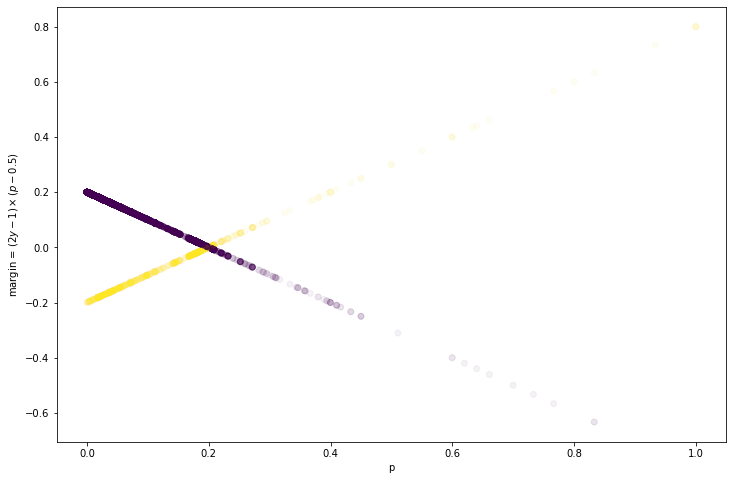

In [72]:
thresh = 0.2
prob_pos = BG_model.best_estimator_.predict_proba(df_test_features.drop(["TARGET"],axis =1))[:,1]
plt.figure(figsize=(12, 8))
margins = (prob_pos-thresh)*(2*df_test_features["TARGET"]-1)
plt.scatter(prob_pos, margins, c=df_test_features["TARGET"], alpha=0.05)
plt.xlabel('p')
plt.ylabel(r"margin = $(2y -1)\times (p-0.5)$")

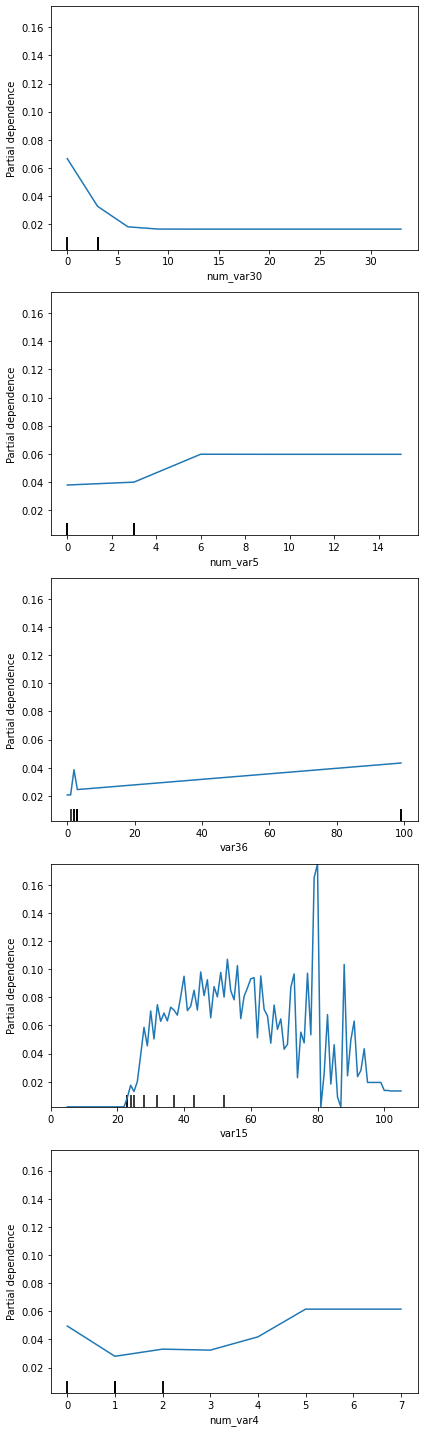

In [78]:
fig, axes = plt.subplots(5, 1, figsize = (6, 20))
#Consider the top 5 important features and graph the ICE plot
plot_partial_dependence(BG_model.best_estimator_,df_train_features.drop(['TARGET'],axis=1),[0,1,2,3,4],grid_resolution=200,ax = axes)
fig.tight_layout()

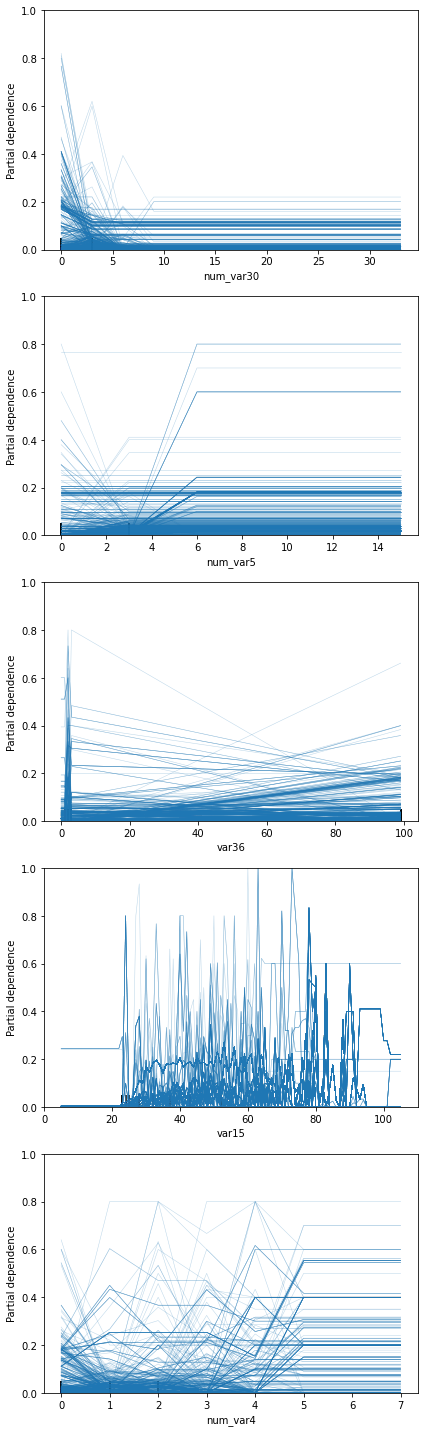

In [79]:
fig, axes = plt.subplots(5, 1, figsize = (6, 20))
#Consider the top 5 important features and graph the ICE plot
plot_partial_dependence(BG_model.best_estimator_,df_train_features.drop(['TARGET'],axis=1),[0,1,2,3,4],grid_resolution=200,ax = axes,kind='individual')
fig.tight_layout()

Calibrating the model

In [82]:
calib = CalibratedClassifierCV(BG_model.best_estimator_,cv=5)
calib.fit(df_train_features.drop(["TARGET"],axis =1),df_train_features["TARGET"])


CalibratedClassifierCV(base_estimator=BaggingClassifier(n_estimators=5,
                                                        random_state=42),
                       cv=5)

In [86]:
calib.score(df_train_features.drop(["TARGET"],axis =1),df_train_features["TARGET"])

0.9607077084977638

In [87]:
calib.score(df_test_features.drop(["TARGET"],axis =1),df_test_features["TARGET"])

0.9608436376392178

<AxesSubplot:>

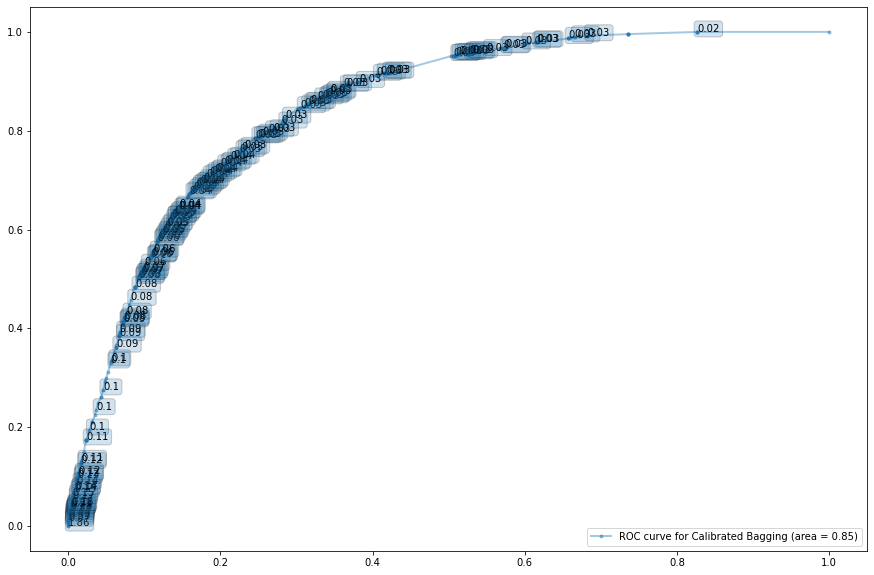

In [83]:
fig,ax = plt.subplots(figsize=(15,10))
make_roc('Calibrated Bagging',calib,df_test_features["TARGET"],df_test_features.drop(["TARGET"],axis = 1),ax=ax)

In [84]:
print(classification_report(df_test_features["TARGET"], calib.predict(df_test_features.drop(["TARGET"],axis = 1))))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21906
           1       0.64      0.02      0.03       900

    accuracy                           0.96     22806
   macro avg       0.80      0.51      0.51     22806
weighted avg       0.95      0.96      0.94     22806



In [85]:
print(confusion_matrix(df_test_features["TARGET"], calib.predict(df_test_features.drop(["TARGET"],axis = 1))))

[[21897     9]
 [  884    16]]


In [ ]:
final_test